In [45]:
import sys

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

sys.path.append('../src')
import utils

# Iterative Methods for Optimization

A general optimization problem has the form

\begin{align}
\min_x & \quad f_0(x) \\
\text{subject to} & \quad f_i(x) \leq b_i, \quad i = 1, \dots, m,
\end{align}

with components
* $x \in \mathbf{R}^n$ - optimization variable,
* $f_0: \mathbf{R}^n \to \mathbf{R}$ - objective function,
* $f_i: \mathbf{R}^n \to \mathbf{R}$ - constraint functions, and
* $b_i \in \mathbf{R}$: constraint bounds.

Very few optimization problems have a closed-form solution, so most problems are solved using iterative methods.
This notebook introduces gradient descent, a fundamental iterative method for solving unconstrained optimization problems of the form

$$\min_x f(x)$$

with $x \in \mathbf{R}^n$ and $f: \mathbf{R}^n \to \mathbf{R}$, where $f$ is differentiable. Our examples use [convex functions](https://en.wikipedia.org/wiki/Convex_function), but the intuition gained from the exercises can also be helpful for nonconvex functions.

Iterative methods start with an initial guess $x^0$.
Each iteration, a new value $x^{k+1}$ is generated based on the previous value $x^k$, often using local information such as the gradient $\nabla f(x^k)$ or Hessian $\nabla^2 f(x^k)$.
The algorithm terminates when a stopping condition is satisfied, which can be specified in terms of the size of the gradient, $\| \nabla f(x^k) \| < \epsilon$, the difference between successive iterates, $\| x^{k+1} - x^k \| < \epsilon$ or $\| f(x^{k+1}) - f(x^k) \| < \epsilon$, or a maximum number of iterations, $k > k_{\max}$.

# Gradient Descent

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is built upon the fact that the gradient of a function always points in the direction of maximum ascent, so the negative gradient points in the direction of maximum descent.
Therefore, starting at the point $x^k$ and taking a step in the direction of the negative gradient, we should arrive at a point $x^{k+1}$ that has a smaller function value, i.e., $f(x^{k+1}) < f(x^k)$.
After multiple iterations, we hope to approximate the optimal solution $x^* = \text{argmin}_x f(x)$.

Here's the algorithm for gradient descent with initial guess $x^0$, step size $\alpha$, and stopping condition based on the size of the gradient:

> **input** $x^0$, $\alpha$, $\epsilon$  
> **set** $k = 0$  
> **while** $\| \nabla f(x^k) \| \geq \epsilon$ **do**  
> &nbsp;&nbsp;&nbsp;&nbsp;$x^{k+1} \leftarrow x^k - \alpha \nabla f(x^k)$  
> &nbsp;&nbsp;&nbsp;&nbsp;$k \leftarrow k + 1$  
> **end while**

##### How do we choose the initial guess?

Depending upon the problem, the initial guess can influence the value of the solution, the number of iterations needed to converge to a solution, or whether or not the algorithm converges at all.
Determining a "good" initial guess is a difficult problem itself, especially when $x$ is high-dimensional, so heuristics are often useful:
* $x^0$ = a vector of ones or zeros
* $x^0$ = a random vector
* $x^0$ = the solution to a similar, but easier, problem

##### How do we choose the step size?

The step size influences the rate of convergence.
If the step size is too small, it may take many more iterations to converge.
However, if the step size is too large, we may overshoot the optimal point.
If you are really unlucky, you could choose a step size that results in the iterates cycling through the same points forever.

In some cases, we can guarantee convergence based on the step size. For example, if a function is convex,

$$f( \lambda x + (1 - \lambda) y ) \leq \lambda f(x) + (1 - \lambda) f(y) \quad \text{for all} \quad x, y \in \mathbf{R}^n \quad \text{and} \quad 0 \leq \lambda \leq 1,$$

and continuously differentiable with a $\beta$-Lipschitz gradient for some $\beta > 0$,

$$\| \nabla f(x) - \nabla f(y) \| \leq \beta \| x - y\| \quad \text{for all} \quad x, y \in \mathbf{R}^n,$$

then after $k$ iterations with a step size $\alpha \leq 1/\beta$, we will have

$$f(x^k) - f(x^*) \leq \frac{\| x^0 - x^* \|^2}{2\alpha k}.$$

This means that gradient descent will converge at a rate of $\mathcal{O}(1/k)$.

As an example, consider the linear least-squares problem, where $f(x) = \frac{1}{2}\|Ax - b\|^2$.
The objective is convex and differentiable, with $\nabla f(x) = A^T(Ax - b)$.
To find the Lipschitz constant for the gradient, note that

$$\| \nabla f(x) - \nabla f(y) \| = \| A^TA(x - y) \| \leq \| A^TA \| \| x - y\|,$$

which follows from the definition of the induced matrix norm

$$\|A\| = \max_{x \neq 0} \frac{\|Ax\|}{\|x\|}.$$

Therefore, using a step size $\alpha \leq 1/\beta$, where $\beta = \|A^TA\|$, we are guaranteed to converge at a linear rate.

Other approaches for adaptively choosing step sizes include:
* [line search methods](https://en.wikipedia.org/wiki/Line_search): optimizing the step size along a given descent direction
* [trust region methods](https://en.wikipedia.org/wiki/Trust_region): optimizing the descent direction for a given step size

##### How do we choose the stopping condition?

For an unconstrained problem where $f$ is convex and differentiable, a point $x$ is optimal if and only if $\nabla f(x) = 0$, so it's natural to terminate gradient descent once the gradient becomes "small enough", i.e., $\| \nabla f(x) \| < \epsilon$.
For constrained problems, stopping conditions can similarly be derived from the [KKT conditions](https://en.wikipedia.org/wiki/Karush-Kuhn-Tucker_conditions), which are necessary, and in convex cases sufficient, conditions for optimality.

Another option is to stop iterating once the difference between successive iterates becomes small, i.e., $\|x^{k+1} - x^k\| < \epsilon$ or $\|f(x^{k+1}) - f(x^k)\| < \epsilon$. In the case of gradient descent, where the difference between iterates is influenced by the size of the gradient, these stopping conditions turn out to be similar to stopping once the gradient becomes small.

When it comes to choosing $\epsilon$, we need to balance convergence with the needs of the problem. On the one hand, if $\epsilon$ is too large, the algorithm will terminate before converging to a good solution. On the other hand, setting $\epsilon$ too small will cause the algorithm to take an unnecessarily long time. For example, if our data was recorded up to three decimal points, there would be no need to iterate until $\|x^{k+1} - x^k\| <$ 1e-6 when $\epsilon =$ 1e-3 should be sufficient. In addition to the precision of our data, another consideration for choosing $\epsilon$ is the signal-to-noise ratio in the data.

## Exercise 1: Step Size

In the example below, experiment with the step size to answer the following questions:
* What happens if the step size is too small? Try 0.0001.
* What happens if the step size is too big? Try 1.001.
* Can you find a step size that converges in one step?
* What is the Lipschitz constant of the gradient? What happens if you set the step size to $1/\beta$ or $1/\beta \pm 0.1$?

Converged after 8 iteration(s).
Minimum function value: 0.00
Total time: 0.00 secs


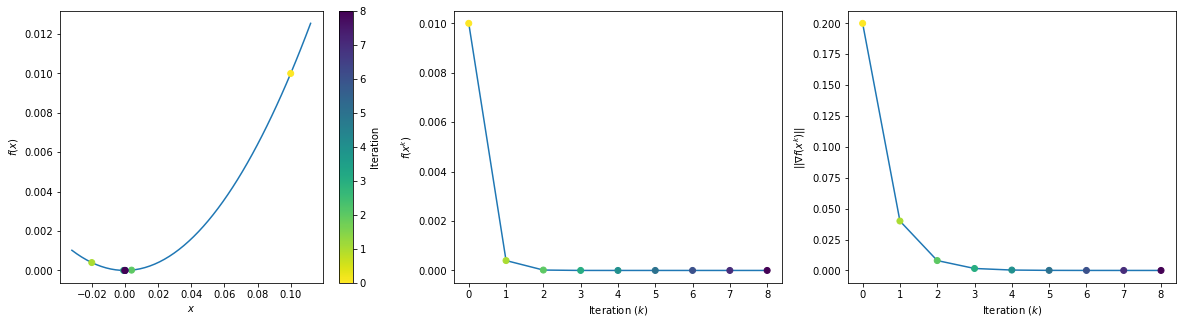

In [64]:
step = 0.75 # modify this variable
func = lambda x: x**2
grad = lambda x: 2*x
results = utils.gradient_descent(func, grad, step=0.6, x0=0.1)
utils.plot_1d(func, results)

## Exercise 2: Initial Guess

In the example below, experiment with the initial guess to answer the following questions:
* Trying different values of x0, can you find a relationship between the shape of the function, the initial guess, and the number of iterations?
* Trying different values of $c \in (-2, 2)$, can you find a relationship between the shape of the function, the initial guess, and the number of iterations?

##### Condition Number

For $c \in (-2, 2)$, the function $f(x,y) = x^2 + cxy + y^2$ describes an ellipsoid with a constant Hessian $\nabla^2 f(x, y)$.
The [condition number](https://en.wikipedia.org/wiki/Condition_number#Matrices) of the matrix $\nabla^2 f(x, y)$, the ratio of its largest eigenvalue to its smallest eigenvalue, gives a measure of the ellipsoid's eccentricity:
* A condition number near one means that the ellipsoid is nearly spherical, and different initial conditions along a sublevel set will converge in a similar number of iterations. To see this, try values of $c$ near zero and initial guesses $x^0 = (\pm 1, \pm 1)$.
* A large condition number indicates that the sublevel sets are much wider in some directions than in others, so different initial conditions along a sublevel set could take much longer to converge than others. To see this, try values of $c$ near 2 and initial guesses $x^0 = (\pm 1, \pm 1)$. 

Condition number of the Hessian: 59617770476389832.00
Converged after 30 iteration(s).
Minimum function value: 0.00
Total time: 0.01 secs


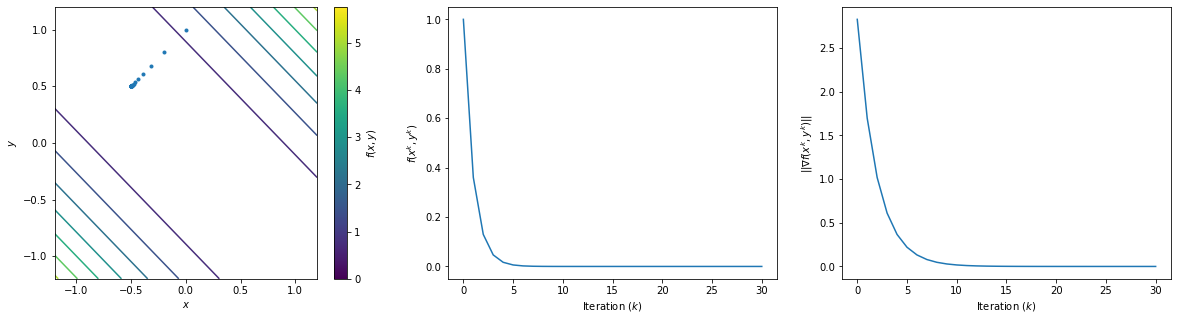

In [43]:
x0 = [0, 1]; c = 2 # modify these variables
func = lambda x: x[0]**2 + c*x[0]*x[1] + x[1]**2
grad = lambda x: np.array([2*x[0] + c*x[1], 2*x[1] + c*x[0]])
hess = [[2, c], [c, 2]]
print(f'Condition number of the Hessian: {np.linalg.cond(hess):.2f}')
results = utils.gradient_descent(func, grad, x0=x0, step=0.1)
utils.plot_2d(func, results)